<h1>Week 1 & 2 - RideWise </h1>

In [18]:
import pandas as pd
pd.options.display.max_columns=99
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor


# Load dataset
bike_dataset = pd.read_csv('/kaggle/input/bike-sharing-dataset/hour.csv')

In [2]:
# Check if there is any none(missing) values in the dataset to decide if will make a data cleaning or not
bike_dataset.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [3]:
# Rename some columns
print(bike_dataset.columns)
bike_dataset = bike_dataset.rename(columns={'yr':'year',
                                            'mnth':'month',
                                            'hum':'humidity',
                                            'weathersit':'weather',
                                            'cnt':'count',
                                           'hr':'hour'})
# Show dataset columns after rename some columns
print(bike_dataset.columns)

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
Index(['instant', 'dteday', 'season', 'year', 'month', 'hour', 'holiday',
       'weekday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'count'],
      dtype='object')


In [4]:
print(len(bike_dataset.columns))

17


In [5]:
for col in bike_dataset.columns:
    # This condition selects the same columns as before
    if col not in ['instant','dteday','count','registered','casual','windspeed','humidity','atemp','temp']:
        # Calculate the counts for the current column
        counts = bike_dataset[col].value_counts()

# change the distribution of count column
bike_dataset['count'] = np.log(bike_dataset['count'])

In [6]:
# 1. Bivariate analysis for weekday and count
weekday_relation = bike_dataset.pivot_table(index='weekday', values='count', aggfunc='mean', observed=False)

# 2. Bivariate analysis for holiday and count
holiday_relation = bike_dataset.pivot_table(index='holiday', values='count', aggfunc='mean', observed=False)

# 3. Bivariate analysis for season and count
season_relation = bike_dataset.pivot_table(index='season', values='count', aggfunc='mean', observed=False)

# 4. Bivariate analysis for month and count
month_relation = bike_dataset.pivot_table(index='month', values='count', aggfunc='mean', observed=False)

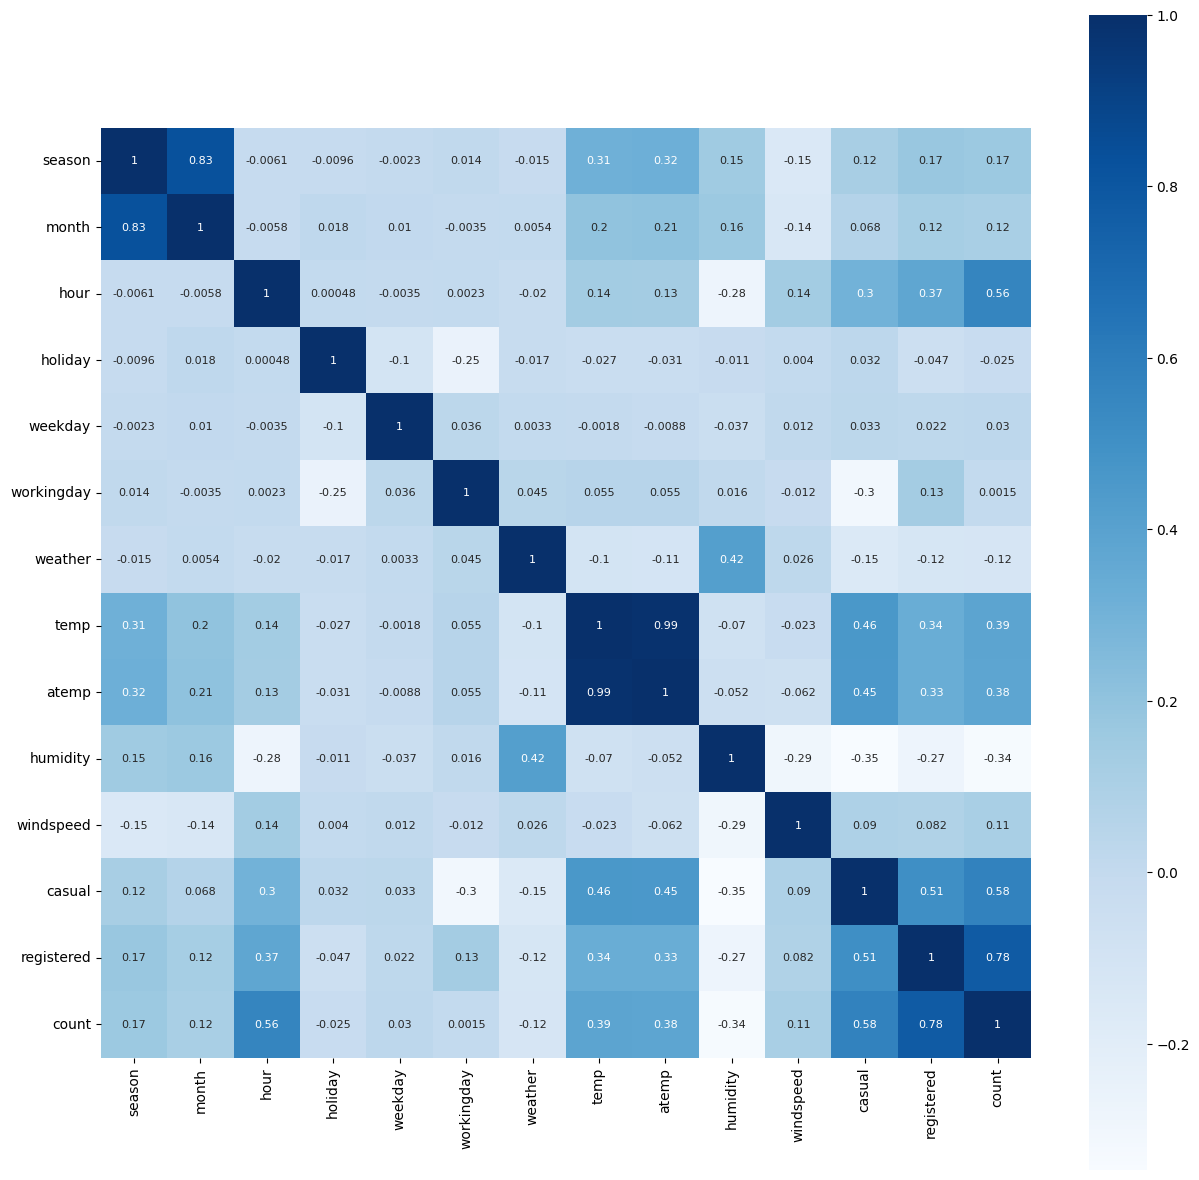

In [7]:
bike_dataset = bike_dataset.drop(columns=['instant','dteday','year'],axis=1)

# Find correlation between all dataset features
correlation_values = bike_dataset.corr()
# plot correlation 
plt.figure(figsize=(15,15))
sns.heatmap(correlation_values,cbar=True,square=True,annot=True,annot_kws={'size':8},cmap='Blues')
plt.show() 

In [8]:
cols = ['season','month','hour','holiday','weekday','workingday','weather']
for col in cols:
    bike_dataset[col] = bike_dataset[col].astype('category')

bike_dataset.head()
bike_dataset_oh = bike_dataset
bike_dataset_oh.head()

def one_hot_encoder(data,column):
    data = pd.concat([data,pd.get_dummies(bike_dataset[column],prefix=column,drop_first=True)],axis=1)
    data = data.drop(columns = [column],axis=1)
    return data
for col in cols:
    bike_dataset_oh = one_hot_encoder(bike_dataset_oh,col)

<h1>Week 3</h1>

In [9]:
# Split data into input and label data
X = bike_dataset_oh.drop(columns=['atemp','windspeed','casual','registered','count'],axis=1)
Y = bike_dataset_oh['count']

# Split data into train and test data
x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.7)
print(X.shape,x_train.shape,x_test.shape)
print(Y.shape,y_train.shape,y_test.shape)

def plot_train_test(y_train,predicted_y_train,y_test,predicted_y_test):
    plt.figure(figsize=(7,7))
    plt.scatter(y_train,predicted_y_train,color='red',marker='X')
    plt.plot(range(int(min(y_train)),int(max(y_train))),color='black')
    plt.title('show actual and predicted train values')
    plt.xlabel('actual values')
    plt.ylabel('predicted values')
    plt.show()
    plt.scatter(y_test,predicted_y_test,color='blue',marker='o')
    plt.plot(range(int(min(y_test)),int(max(y_test))),color='black')
    plt.title('show actual and predicted test values')
    plt.xlabel('actual values')
    plt.ylabel('predicted values')
    plt.show()

(17379, 50) (12165, 50) (5214, 50)
(17379,) (12165,) (5214,)


In [10]:
# Train model and test it
def Train_predict(model,x_train,x_test,y_train,y_test):
    # Train model 
    model.fit(x_train,y_train)
    # Make the model predict on train and test input data
    predicted_train_data = model.predict(x_train)
    predicted_test_data = model.predict(x_test)
    # plot difference between predicted and actual values
    plot_train_test(y_train,predicted_train_data,y_test,predicted_test_data)
    # Evaluate model
    train_r2 = r2_score(y_train, predicted_train_data)
    test_r2  = r2_score(y_test, predicted_test_data)

    train_rmse = np.sqrt(mean_squared_error(y_train, predicted_train_data))
    test_rmse  = np.sqrt(mean_squared_error(y_test, predicted_test_data))

    train_mae = mean_absolute_error(y_train, predicted_train_data)
    test_mae  = mean_absolute_error(y_test, predicted_test_data)

    # Adjusted R²
    n_train, n_test = len(y_train), len(y_test)
    p = x_train.shape[1]

    def adj_r2(r2, n, p):
        if n - p - 1 <= 0:
            return np.nan
        return 1 - (1 - r2) * (n - 1) / (n - p - 1)

    train_adj_r2 = adj_r2(train_r2, n_train, p)
    test_adj_r2  = adj_r2(test_r2, n_test, p)
    return [
        train_r2, test_r2,
        train_adj_r2, test_adj_r2,
        train_rmse, test_rmse,
        train_mae, test_mae
    ]

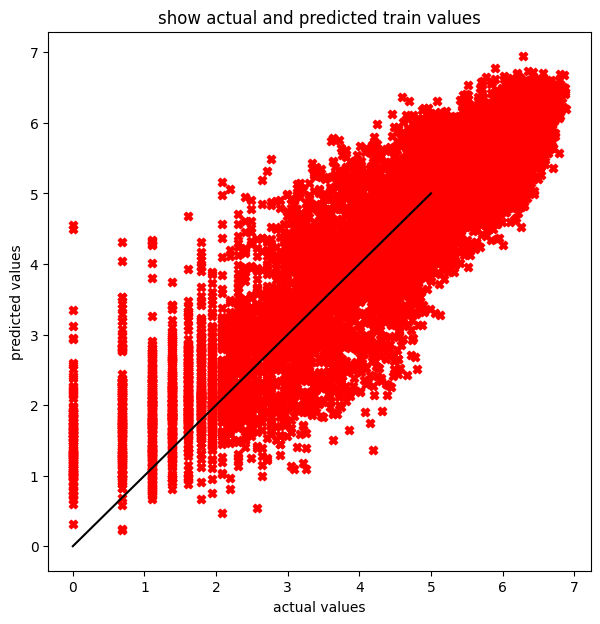

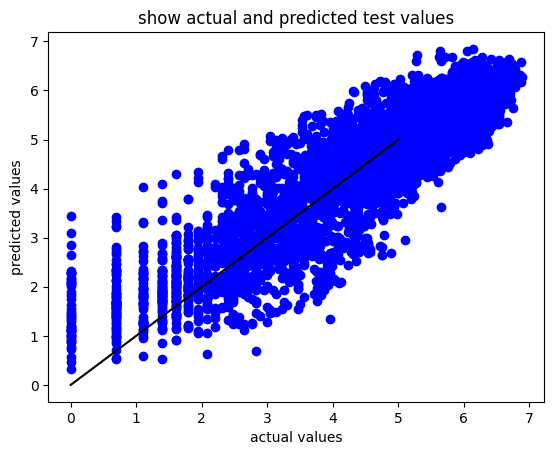


Model: LinearRegression
 R2 (train/test):        0.7978 / 0.7989
 Adj R2 (train/test):    0.7969 / 0.7969
 RMSE (train/test):      0.6660 / 0.6717
 MAE  (train/test):      0.5044 / 0.5106
--------------------------------------------------


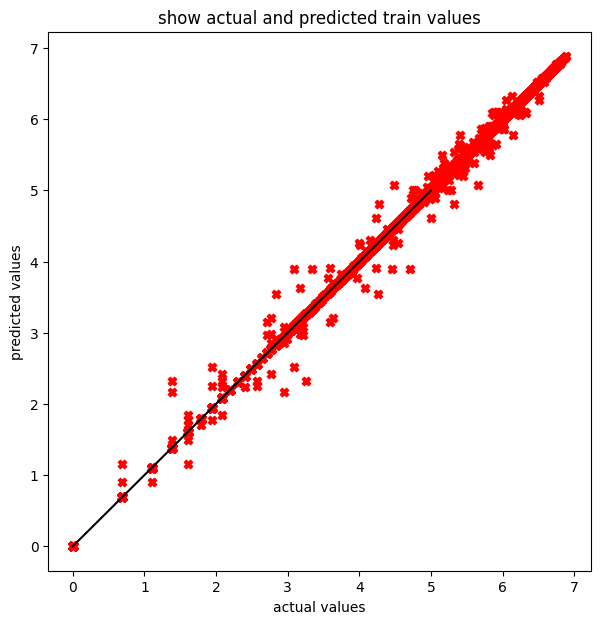

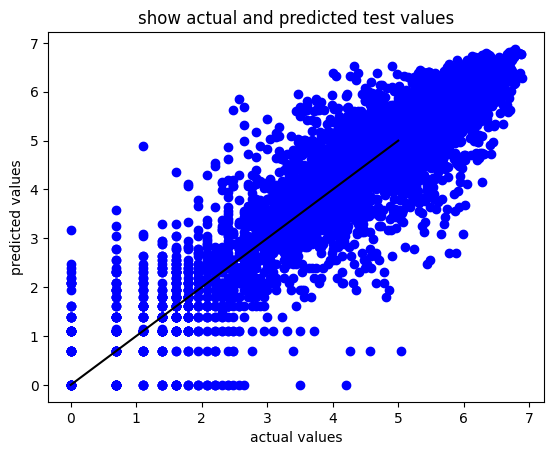


Model: DecisionTreeRegressor
 R2 (train/test):        0.9995 / 0.7881
 Adj R2 (train/test):    0.9995 / 0.7861
 RMSE (train/test):      0.0344 / 0.6894
 MAE  (train/test):      0.0032 / 0.4803
--------------------------------------------------


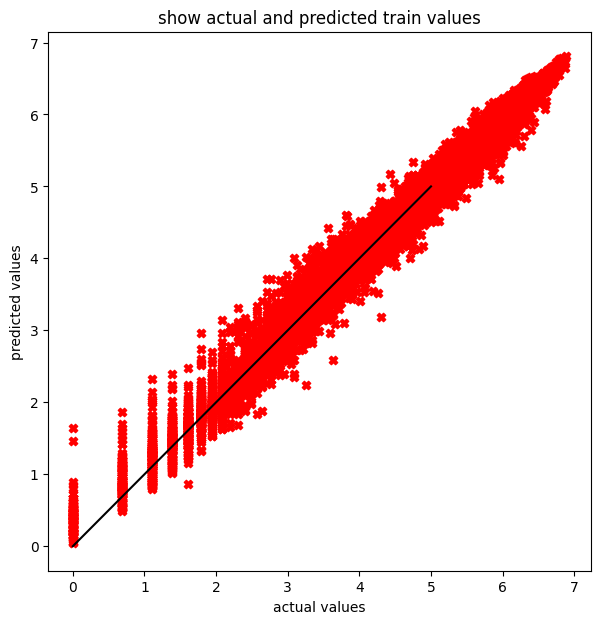

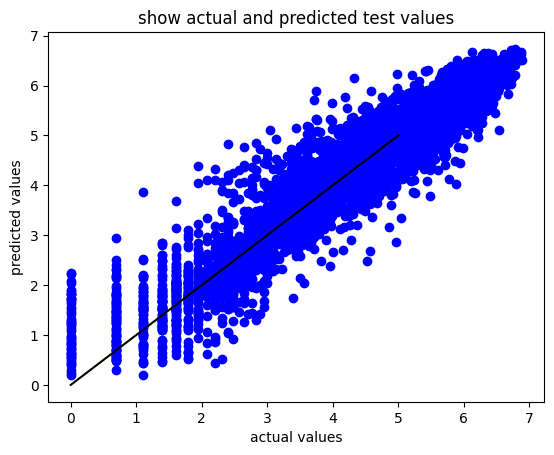


Model: RandomForestRegressor
 R2 (train/test):        0.9843 / 0.8930
 Adj R2 (train/test):    0.9842 / 0.8920
 RMSE (train/test):      0.1856 / 0.4899
 MAE  (train/test):      0.1338 / 0.3595
--------------------------------------------------


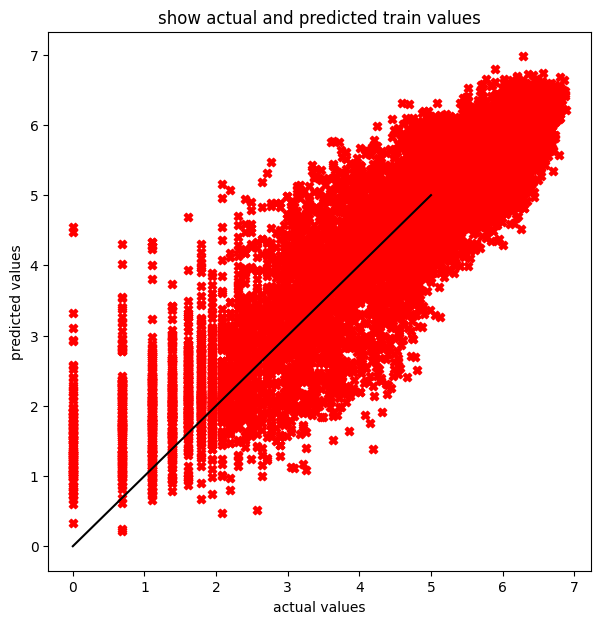

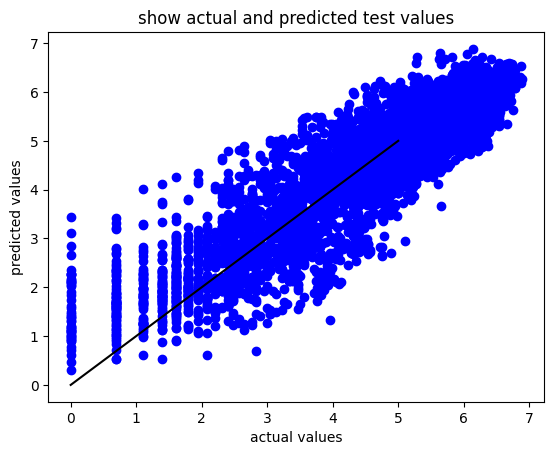


Model: Ridge
 R2 (train/test):        0.7979 / 0.7990
 Adj R2 (train/test):    0.7970 / 0.7971
 RMSE (train/test):      0.6659 / 0.6715
 MAE  (train/test):      0.5045 / 0.5107
--------------------------------------------------


In [11]:
Models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    Ridge(),
]

for model in Models:
    res = Train_predict(model, x_train, x_test, y_train, y_test)

    def fmt(x):
        return f"{x:.4f}" if (x is not None and not (isinstance(x, float) and np.isnan(x))) else "n/a"

    print("\nModel:", model.__class__.__name__)
    print(" R2 (train/test):       ", fmt(res[0]), "/", fmt(res[1]))
    print(" Adj R2 (train/test):   ", fmt(res[2]), "/", fmt(res[3]))
    print(" RMSE (train/test):     ", fmt(res[4]), "/", fmt(res[5]))
    print(" MAE  (train/test):     ", fmt(res[6]), "/", fmt(res[7]))
    print("-" * 50)

In [17]:
# Create some hypothetical scenarios (rows)
# Train RandomForest on your training set and keep it
final_model = RandomForestRegressor(random_state=42)
final_model.fit(x_train, y_train)

test_cases = pd.DataFrame([
    {
        "season": 2, "year": 1, "month": 6, "hour": 17,
        "holiday": 0, "weekday": 4, "workingday": 1,
        "weather": 1, "temp": 0.50, "atemp": 0.48,
        "humidity": 0.55, "windspeed": 0.20
    }, 
    {
        "season": 3, "year": 1, "month": 6, "hour": 19,
        "holiday": 0, "weekday": 6, "workingday": 0,
        "weather": 1, "temp": 0.80, "atemp": 0.6970,
        "humidity": 0.27, "windspeed": 0.1940
    },
    {
        "season": 1, "year": 1, "month": 1, "hour": 20,
        "holiday": 1, "weekday": 1, "workingday": 0,
        "weather": 1, "temp": 0.24, "atemp": 0.2273,
        "humidity": 0.41, "windspeed": 0.2239
    },
    {
        "season": 2, "year": 1, "month": 5, "hour": 19,
        "holiday": 0, "weekday": 2, "workingday": 1,
        "weather": 1, "temp": 0.78, "atemp": 0.7121,
        "humidity": 0.52, "windspeed": 0.3582
    }
])
def preprocess_new(df):
    df = df.copy()
    df = df.rename(columns={'yr':'year','mnth':'month','hr':'hour',
                            'hum':'humidity','weathersit':'weather'})
    # Drop columns not in X
    drop_cols = [c for c in ['instant','dteday','casual','registered','count','atemp','windspeed']
                 if c in df.columns]
    df = df.drop(columns=drop_cols, errors='ignore')
    for col in ['season','month','hour','holiday','weekday','workingday','weather']:
        df[col] = df[col].astype('category')
    df_oh = df.copy()
    for col in ['season','month','hour','holiday','weekday','workingday','weather']:
        df_oh = pd.concat([df_oh,
                           pd.get_dummies(df_oh[col], prefix=col, drop_first=True)],
                          axis=1).drop(columns=[col])
    # Align columns with training set
    return df_oh.reindex(columns=X.columns, fill_value=0)

test_cases_oh = preprocess_new(test_cases)

# Predict with the trained RandomForest model
predictions_log = final_model.predict(test_cases_oh)
predictions = np.exp(predictions_log) 

# Display nicely
for i, p in enumerate(predictions, 1):
    print(f"Scenario {i} → Predicted rentals: {int(p)}")

Scenario 1 → Predicted rentals: 104
Scenario 2 → Predicted rentals: 357
Scenario 3 → Predicted rentals: 89
Scenario 4 → Predicted rentals: 478


In [21]:
# Save the trained RandomForest model
joblib.dump(final_model, "ridewise_model.pkl")

# Load it back
loaded_model = joblib.load("ridewise_model.pkl")

# Predict on the first scenario (needs the processed version)
pred_log = loaded_model.predict(test_cases_oh.iloc[[2]])[0]
predicted_count = int(np.exp(pred_log))

print("Reloaded model prediction:", predicted_count)

Reloaded model prediction: 89
